<a href="https://colab.research.google.com/github/lauraluebbert/US_gun_violence/blob/main/gun_violence_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data source: https://www.gunviolencearchive.org

___

Load the data:

In [1]:
!git clone https://github.com/lauraluebbert/US_gun_violence.git

fatal: destination path 'US_gun_violence' already exists and is not an empty directory.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
fsize = 15
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv("US_gun_violence/all.tsv", sep="\t")
df["date"] = pd.to_datetime(df["date"])

___

Split data into categories:

In [4]:
defense = df[df["category"] == "defense"]
mass = df[df["category"] == "mass_shooting"]
teens = df.query("category == 'teens'")
children = df.query("category=='children'")

In [5]:
teens_f = teens[~teens["id"].isin(children["id"])]
children_f = children[~children["id"].isin(teens["id"])]
df_kids = pd.concat([teens_f, children_f])

In [6]:
df_defense_m = defense[~defense["id"].isin(mass["id"])]
df_mass = mass[~mass["id"].isin(defense["id"])]

df_md = pd.concat([df_defense_m, df_mass])

In [7]:
df_defense_m.index = df_defense_m["date"]
df_mass.index = df_mass["date"]

df_kids.index = df_kids["date"]

In [8]:
defense_m_num_incident = df_defense_m.resample("M")["killed"].count() # number of incidences
defense_m_num_killed = df_defense_m.resample("M")["killed", "injured"].sum().sum(1) # number of deaths and injuries

mass_num_incident = df_mass.resample("M")["killed"].count() # number of incidences
mass_num_killed = df_mass.resample("M")["killed", "injured"].sum().sum(1) # number of deaths and injuries

kids_num_incident = df_kids.resample("M")["killed"].count() # number of incidences
kids_num_killed = df_kids.resample("M")["killed", "injured"].sum().sum(1) # number of deaths and injuries

Plot deaths and injuries over time:

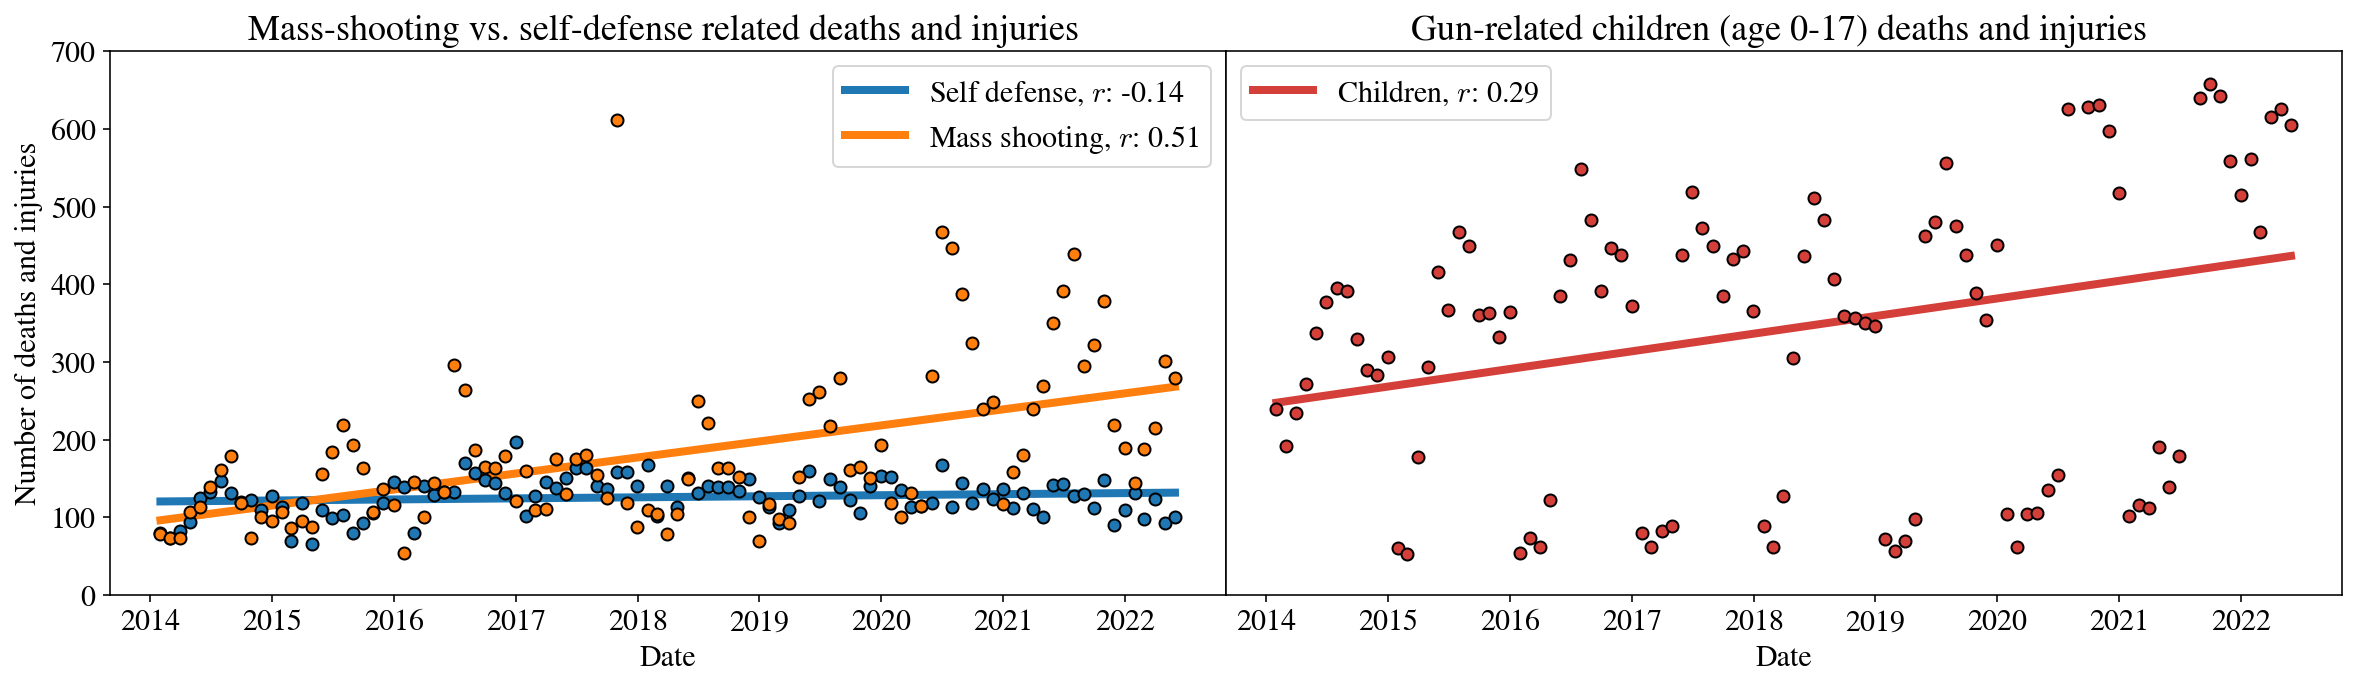

In [9]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=2)
fig.subplots_adjust(wspace=0)
ax = axs[0]
x = defense_m_num_killed.index
y = defense_m_num_killed.values

xx = (x - x[0]).days.values
reg = LinearRegression().fit(xx.reshape(-1,1), y)
xxx = np.array([xx.min(), xx.max()])
yyy = reg.coef_*xxx + reg.intercept_
r = np.sqrt(reg.score(xx.reshape(-1,1), y))

ax.scatter(x,y, edgecolor="k")
ax.plot([x[0], x[-1]], [yyy[0], yyy[-1]],  label=f"Self defense, $r$: -{r:,.2f}", linewidth=4, zorder=-1)

x = mass_num_killed.index
y = mass_num_killed.values

xx = (x - x[0]).days.values
reg = LinearRegression().fit(xx.reshape(-1,1), y)
xxx = np.array([xx.min(), xx.max()])
yyy = reg.coef_*xxx + reg.intercept_
r = np.sqrt(reg.score(xx.reshape(-1,1), y))

ax.scatter(x,y, edgecolor="k")
ax.plot([x[0], x[-1]], [yyy[0], yyy[-1]], label=f"Mass shooting, $r$: {r:,.2f}", linewidth=4, zorder=-1)

ax.legend()

ax.set(**{
    "xlabel": "Date",
    "ylabel": "Number of deaths and injuries",
    "title": "Mass-shooting vs. self-defense related deaths and injuries ",
    "ylim": (0, 700), # 5000),
})

ax = axs[1]
x = kids_num_killed.index
y = kids_num_killed.values

xx = (x - x[0]).days.values
reg = LinearRegression().fit(xx.reshape(-1,1), y)
xxx = np.array([xx.min(), xx.max()])
yyy = reg.coef_*xxx + reg.intercept_
r = np.sqrt(reg.score(xx.reshape(-1,1), y))

ax.scatter(x,y, color="#D43F3A", edgecolor="k")
ax.plot([x[0], x[-1]], [yyy[0], yyy[-1]], label=f"Children, $r$: {r:,.2f}", color="#D43F3A", linewidth=4, zorder=-1)

ax.legend()

ax.set(**{
    "xlabel": "Date",
    "ylabel": "",
    "title": "Gun-related children (age 0-17) deaths and injuries ",
    "ylim": (0, 700), # 5000),
    "yticks": [],
    "yticklabels": []
})

fig.savefig("correlation.png", dpi=300, bbox_inches="tight", background="white")
fig.show()

Plot number of gun-related children (age 0-17) deaths and injuries per month:

In [62]:
per_month = df_kids.groupby([df_kids.index.year,df_kids.index.month])["killed", "injured"].sum().sum(1)

a = np.zeros((9, 12))
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for idx, y in enumerate(years):
  for jdx, v in enumerate(per_month[y].values):
    # to account for 2022 being incomplete
    a[idx][jdx] = v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


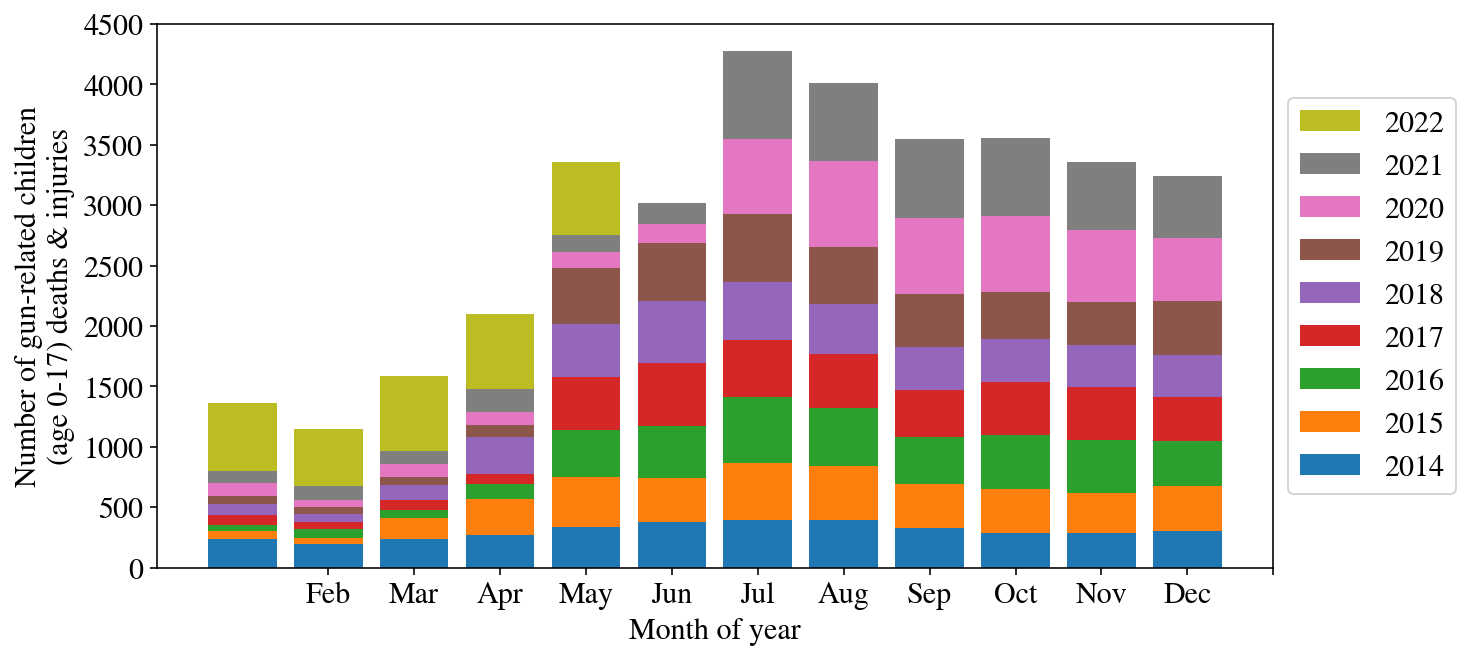

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(months, a[0], label=years[0])
for i in range(1, 9):
  ax.bar(months, a[i], bottom=a[:i].sum(0), label=years[i])

ax.set(**{
    "xticks": np.arange(12)+1,
    "xlabel": "Month of year",
    "ylabel": "Number of gun-related children\n(age 0-17) deaths & injuries",
    "ylim": (0, 4500)
})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("children-per-month.png", dpi=300, bbox_inches="tight", background="white")
fig.show()

Plot number of mass shooting deaths and injuries per month:

In [54]:
per_month = df_mass.groupby([df_mass.index.year,df_mass.index.month])["killed", "injured"].sum().sum(1)

a = np.zeros((9, 12))
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for idx, y in enumerate(years):
  for jdx, v in enumerate(per_month[y].values):
    # to account for 2022 being incomplete
    a[idx][jdx] = v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


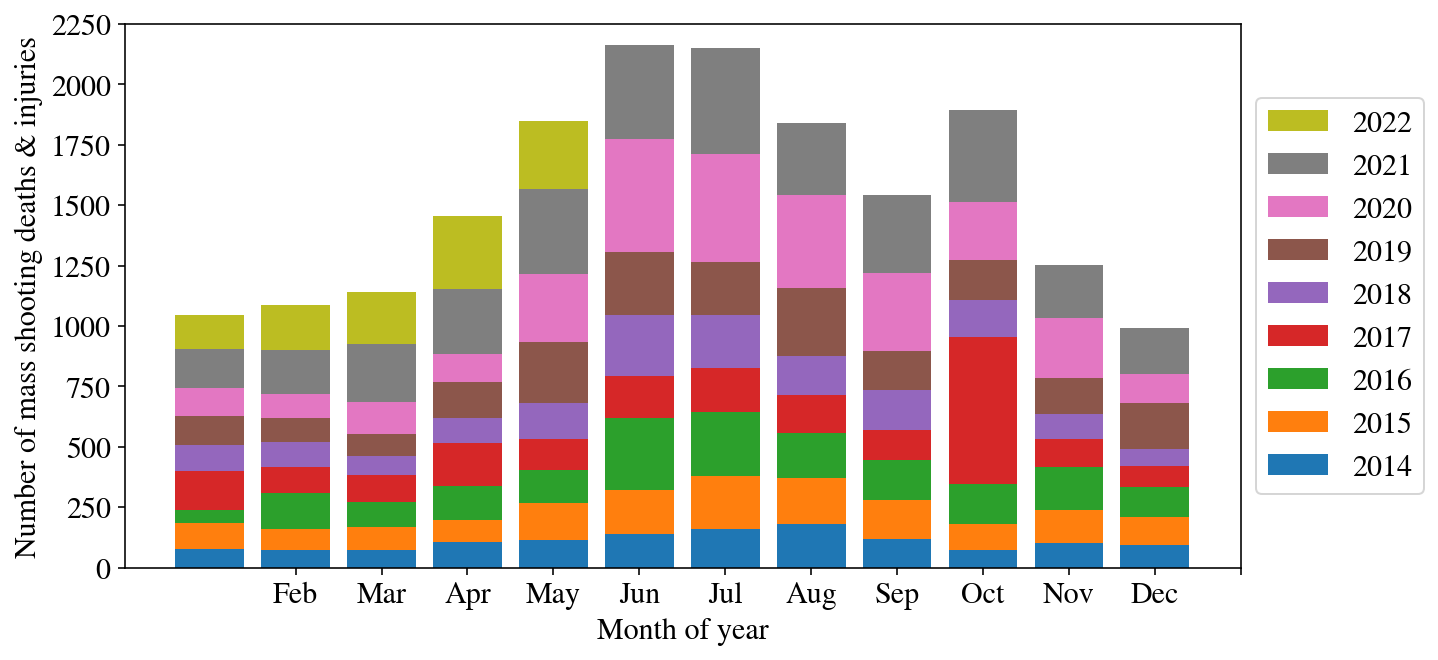

In [59]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(months, a[0], label=years[0])
for i in range(1, 9):
  ax.bar(months, a[i], bottom=a[:i].sum(0), label=years[i])

ax.set(**{
    "xticks": np.arange(12)+1,
    "xlabel": "Month of year",
    "ylabel": "Number of mass shooting deaths & injuries",
    "ylim": (0, 2250)
})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("mass-per-month.png", dpi=300, bbox_inches="tight", background="white")
fig.show()

# Prediction

In [14]:
x = kids_num_killed.index
y = kids_num_killed.values

xx = ((x - x[0]) / np.timedelta64(1, 'M')).values
reg = LinearRegression().fit(xx.reshape(-1,1), y)
xxx = np.array([xx.min(), xx.max()])
yyy = reg.coef_*xxx + reg.intercept_
r = np.sqrt(reg.score(xx.reshape(-1,1), y))

In [15]:
print(f"Currently there are {y.mean():,.0f} avg deaths & injuries to children by guns per month")

Currently there are 342 avg deaths & injuries to children by guns per month


In [16]:
print(f"With no interventions we predict {(reg.coef_*[xx.max() + 10*12] + reg.intercept_)[0]:,.0f} deaths & injuries to children by guns per month in 10 years")

With no interventions we predict 664 deaths & injuries to children by guns per month in 10 years
